<a href="https://colab.research.google.com/github/CarlosGG18/Post-Disaster-Semenatic-Segmentation/blob/main/Unet_Tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import cv2
import os
import tensorflow as tf
import keras
from keras.optimizers import SGD, Adam
import random
import segmentation_models as sm
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape,Input,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D,Concatenate
from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
import matplotlib
from keras.callbacks import ModelCheckpoint
from keras.layers.activation.relu import ReLU

Segmentation Models: using `keras` framework.


In [ ]:
def convolution_operation(entered_input, filters=64):
  #Take first input and imp the first conv block
  conv1= Conv2D(filters, 3, padding='same')(entered_input)
  batch_norm1 = BatchNormalization()(conv1)
  act1 = ReLU()(batch_norm1)

  #1st input and imp the 2nd conv block YEAAA
  conv2 = Conv2D(filters,3 ,padding='same')(act1)
  batch_norm2 = BatchNormalization()(conv2)
  act2= ReLU()(batch_norm2)

  return act2

In [ ]:
def encoder(entered_input, filters= 64):
  enc1= convolution_operation(entered_input, filters)
  maxpool1 = MaxPooling2D(2,2)(enc1)
  return enc1, maxpool1

In [ ]:
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out


##Load in images

In [ ]:
#Preprocessing params
train_grid_size =384
resize_dim = (2*train_grid_size, 2*train_grid_size)
height = train_grid_size
width = train_grid_size
img_height = 3000
img_width = 4000
h_n = int(resize_dim[0]/height)
w_n = int(resize_dim[0]/width)
n_classes=10

In [ ]:
wd = os.getcwd()  
train_dir = wd+"/drive/MyDrive/Floodnet/train/train-org-img"    

In [ ]:
train_flooded_images= []
img = os.listdir(train_dir)
img.sort()
for img_path in img:
  img = cv2.imread("/".join((train_dir,img_path)),1)
  img = img[0:img_height, 0:img_width, :]
  img = cv2.resize(img,resize_dim)
  i=0
  j=0
  y=0

  for i in range(h_n):
    x=0
    for j in range(w_n):
      img_crop = img[y:(y+height),x:(x+width),:]
      train_flooded_images.append(img_crop)
      x+=width
    y+=height
train_flooded_images = np.array(train_flooded_images)

In [ ]:
train_mask_dir= wd+"/drive/MyDrive/Floodnet/train/train-label-img"

In [ ]:
train_flooded_mask = []
mask = os.listdir(train_mask_dir)
mask.sort()
for mask_path in mask:
  mask = cv2.imread("/".join((train_mask_dir,mask_path)),0)
  mask = mask[0:img_height,0:img_width]
  mask = cv2.resize(mask, resize_dim)
  i=0
  j=0
  y=0
  for i in range(h_n):
    x=0
    for j in range(w_n):
      mask_crop = mask[y:(y+height),x:(x+width)]
      train_flooded_mask.append(mask_crop)
      x+=width
    y+=height
train_flooded_mask = np.array(train_flooded_mask)

In [ ]:
test_dir = wd+"/drive/MyDrive/Floodnet/test/test-org-img" 

In [ ]:
test_flooded_images= []
img_2= os.listdir(test_dir)
img_2.sort()
for img_path in img_2:
  img = cv2.imread("/".join((test_dir,img_path)),1)
  img = img[0:img_height, 0:img_width, :]
  img = cv2.resize(img,resize_dim)
  i=0
  j=0
  y=0

  for i in range(h_n):
    x=0
    for j in range(w_n):
      img_crop = img[y:(y+height),x:(x+width),:]
      test_flooded_images.append(img_crop)
      x+=width
    y+=height
test_flooded_images = np.array(test_flooded_images)

In [ ]:
test_mask_dir = wd+"/drive/MyDrive/Floodnet/test/test-label-img" 

In [ ]:
test_flooded_mask = []
mask_2= os.listdir(test_mask_dir)
mask_2.sort()
for mask_path in mask_2:
  mask = cv2.imread("/".join((test_mask_dir,mask_path)),0)
  mask = mask[0:img_height,0:img_width]
  mask = cv2.resize(mask, resize_dim)
  i=0
  j=0
  y=0
  for i in range(h_n):
    x=0
    for j in range(w_n):
      mask_crop = mask[y:(y+height),x:(x+width)]
      test_flooded_mask.append(mask_crop)
      x+=width
    y+=height
test_flooded_mask = np.array(test_flooded_mask)

In [ ]:
val_dir = wd+"/drive/MyDrive/Floodnet/val/val-org-img" 

In [ ]:
val_flooded_images= []
img_3= os.listdir(val_dir)
img_3.sort()
for img_path in img_3:
  img = cv2.imread("/".join((val_dir,img_path)),1)
  img = img[0:img_height, 0:img_width, :]
  img = cv2.resize(img,resize_dim)
  i=0
  j=0
  y=0

  for i in range(h_n):
    x=0
    for j in range(w_n):
      img_crop = img[y:(y+height),x:(x+width),:]
      val_flooded_images.append(img_crop)
      x+=width
    y+=height
val_flooded_images = np.array(val_flooded_images)

In [ ]:
val_mask_dir = wd+ "/drive/MyDrive/Floodnet/val/val-label-img"

In [ ]:
val_flooded_mask = []
mask_3= os.listdir(val_mask_dir)
mask_3.sort()
for mask_path in mask_3:
  mask = cv2.imread("/".join((val_mask_dir,mask_path)),0)
  mask = mask[0:img_height,0:img_width]
  mask = cv2.resize(mask, resize_dim)
  i=0
  j=0
  y=0
  for i in range(h_n):
    x=0
    for j in range(w_n):
      mask_crop = mask[y:(y+height),x:(x+width)]
      val_flooded_mask.append(mask_crop)
      x+=width
    y+=height
val_flooded_mask = np.array(val_flooded_mask)

In [ ]:
print('Trainset Images:',train_flooded_images.shape)
print('Trainset Masks:', train_flooded_mask.shape)
print('Trainset Mask labels:', np.unique(train_flooded_mask))
print('------------------------------------------------')
print('Testset Images:',test_flooded_images.shape)
print('Testset Masks:', test_flooded_mask.shape)
print('Testset Mask labels:', np.unique(test_flooded_mask))
print('------------------------------------------------')
print('Validationset Images:',val_flooded_images.shape)
print('Validationset Masks:', val_flooded_mask.shape)
print('Validationset Mask labels:', np.unique(val_flooded_mask))

Trainset Images: (5780, 256, 256, 3)
Trainset Masks: (5780, 256, 256)
Trainset Mask labels: [0 1 2 3 4 5 6 7 8 9]
------------------------------------------------
Testset Images: (1792, 256, 256, 3)
Testset Masks: (1792, 256, 256)
Testset Mask labels: [0 1 2 3 4 5 6 7 8 9]
------------------------------------------------
Validationset Images: (1800, 256, 256, 3)
Validationset Masks: (1800, 256, 256)
Validationset Mask labels: [0 1 2 3 4 5 6 7 8 9]


### Modeling

In [ ]:
def tuned_unet(Image_Size):
  input1 = Input(Image_Size)

  #Add Encoder Blocks
  skip1, encoder_1 = encoder(input1,64)
  skip2, encoder_2 = encoder(encoder_1, 128)
  skip3, encoder_3 = encoder(encoder_2, 256)
  skip4, encoder_4 = encoder(encoder_3, 512)
  skip5, encoder_5 = encoder(encoder_4, 1024)

  #Make last block before decoding
  conv_block = convolution_operation(encoder_5, 2048)

  #Add Decoder 
  dec1 = decoder(conv_block, skip5, 1024)
  dec2 = decoder(dec1, skip4, 512)
  dec3 = decoder(dec2, skip3, 256)
  dec4 = decoder(dec3, skip2, 128)
  dec5 = decoder(dec4, skip1, 64)

  #Output
  out = Conv2D(10, (1,1),activation ='softmax',padding='same')(dec5)
  model = Model(inputs = [input1], outputs = [out])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['sparse_categorical_accuracy'])

  return model

In [ ]:
model = tuned_unet((256,256,3))

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/unet_tuned_model.h5', 
                             monitor='sparse_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto')

In [ ]:
history = model.fit(train_flooded_images, train_flooded_mask, batch_size= 15, verbose=2, epochs=2, validation_data=(val_flooded_images, val_flooded_mask), callbacks=[checkpoint])

Epoch 1/2

Epoch 1: sparse_categorical_accuracy improved from 0.69101 to 0.76256, saving model to /content/drive/MyDrive/unet_tuned_model.h5
386/386 - 5490s - loss: 0.6989 - sparse_categorical_accuracy: 0.7626 - val_loss: 0.6788 - val_sparse_categorical_accuracy: 0.7730 - 5490s/epoch - 14s/step
Epoch 2/2

Epoch 2: sparse_categorical_accuracy improved from 0.76256 to 0.77836, saving model to /content/drive/MyDrive/unet_tuned_model.h5
386/386 - 5450s - loss: 0.6592 - sparse_categorical_accuracy: 0.7784 - val_loss: 0.6855 - val_sparse_categorical_accuracy: 0.7711 - 5450s/epoch - 14s/step


In [ ]:
def evaluate_random_image(model, test_images, test_masks):
    # choose a random test image
    random_index = np.random.choice(len(test_images))
    test_image = test_images[random_index]
    
    #predictions on the test image
    test_image = np.expand_dims(test_image, axis=0)
    predictions = model.predict(test_image)
    
    #predicted mask
    class_id = predictions.argmax(axis=-1)

    #ground truth 
    ground = test_masks[random_index]
    ground = np.squeeze(ground)
    # create a colormap for 10 classes
    cmap = matplotlib.cm.get_cmap('tab10')
    
    # display the test image, predicted mask, ground truth
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(test_image[0])
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(class_id[0])
    plt.title('Predicted Mask')
    plt.axis('off')
    print(class_id[0].shape)

    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.imshow(ground)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.show()
    print(ground.shape)

1/1 [==============================] - 1s 837ms/step
(256, 256)


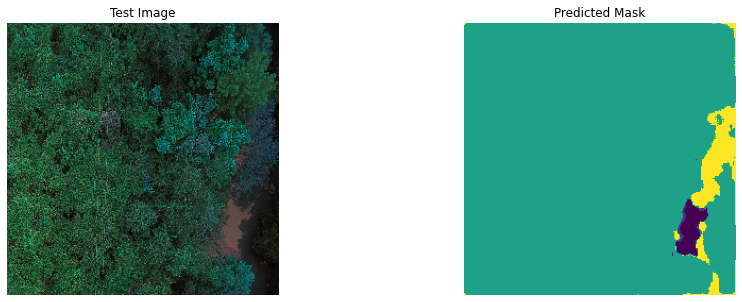

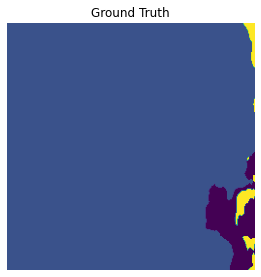

(256, 256)


In [ ]:
evaluate_random_image(model, test_flooded_images, test_flooded_mask)